# running the decoder
now pynapples!
## single animal first

In [1]:
# imports
import sys, os
import numpy as np
import pynapple as nap
import pickle

# a bad idea
from decoder_functions import *

In [2]:
# path definitions
# maybe it's possible to abbreviate this
exp_folder = Path("/media/georg/htcondor/shared-paton/georg/DAtime/data/2023-02-17_JJP-05313-dh_B_1-2-3/")
run_folder = exp_folder / "stim_run_2_g0"
imec_bin_path = run_folder / "stim_run_2_g0_t0.imec0.ap.bin"
ni_bin_path = run_folder / "stim_run_2_g0_t0.nidq.bin"
ks_folder = run_folder / "pyks2_output"
results_folder = ks_folder / "results"

In [2]:
# path definitions
# maybe it's possible to abbreviate this
exp_folder = Path('/media/georg/htcondor/shared-paton/georg/DAtime/data/batch_24a/2024-06-06_JJP-08672_dh_1-6-1')
run_folder = exp_folder / 'stim_run_1_g0'
imec_bin_path = run_folder / 'stim_run_1_g0_t0.imec0.ap.bin'
ni_bin_path = run_folder / 'stim_run_1_g0_t0.nidq.bin'
ks_folder = run_folder / 'ibl_sorter_results'
results_folder = ks_folder / 'results'

In [5]:
# load this dataset
Rates = nap.load_file(str(results_folder / 'unit_rates.npz'))
# Rates = nap.load_file('/home/georg/data_local/unit_rates.npz')
UnitsDf = pd.read_csv(results_folder / 'UnitsDf.csv')
StimsDf = pd.read_csv(run_folder / 'StimsDf.csv')

with open(run_folder / 'stim_classes.pkl', 'rb') as fH:
    stim_classes = pickle.load(fH)
    
# Rates_array = np.load(results_folder / 'frates.npy')
# w = np.load(results_folder / 'w.npy')
# unit_ids = np.load(results_folder / 'frates_units.npy')
# tvec = np.load(results_folder / 'frates_tvec.npy')


In [6]:
# recreating previous reslice
pre, post = -2, 5
stim_times = nap.Ts(t=StimsDf['t'].values)
stim_intervals = nap.IntervalSet(start=stim_times.times()+pre, end=stim_times.times()+post)

# warning, duplication in memory
Rates_resliced = np.stack([Rates.restrict(interval).as_array() for interval in stim_intervals], axis=2)

In [12]:
# setting up decoder resolution
full_res = False

if full_res:
    dr = 0.2
    dt = 0.05
    n_runs = 10
    k_folds = 10

    rvec_decode = np.arange(-4, 4, dr)
    tvec_decode = np.arange(-1.0, 4, dt)
else:
    n_runs = 1
    k_folds = 10
    dr = 0.1
    dt = 0.05
    rvec_decode = np.arange(-4, 4, dr)
    tvec_decode = np.arange(-1.0, 4, dt)

# trial selection
# vpl_inds = np.where(StimsDf.stim_id == '1')[0]
# vpl_da_inds = np.where(StimsDf.stim_id == '2')[0]

# data selection
UnitsDf['selection'] = UnitsDf.sigupmod_vpl * ~UnitsDf.sigmod_da
# UnitsDf['selection'] = UnitsDf.good # * UnitsDf.sigmod_vpl * ~UnitsDf.sigmod_da * UnitsDf.stable
# UnitsDf['selection'] = UnitsDf['group'] == 'good'


In [13]:
# UnitDf['selection'] = UnitDf.sigmod_vpl * ~UnitDf.sigmod_da * UnitDf.stable
unit_ids = np.where(UnitsDf.selection.values)[0]
print("# units in selection: %i" % unit_ids.shape)

# single animal
# with the faith that this will later make sense I continue ... 

R = Rates_resliced[:, unit_ids, :]
Rates_vpl = R[:, :, StimsDf['stim_id'] == 1]
Rates_vpl_da = R[:, :, StimsDf['stim_id'] == 2]

# units in selection: 3


In [38]:
# Multi animal
"""
some notes for the multianimal construction
 - look into the time interpolation issue across 

"""
# Signals = Rates_all
# Meta_Animal = build_metaanimal(Signals, UnitDfs, StimsDfs)
# Rates_vpl = Meta_Animal[0]['1']
# Rates_vpl_da = Meta_Animal[0]['2']


2024-08-23 10:46:29,107 - INFO - run 0
2024-08-23 10:46:29,108 - INFO - kfold-split: dropping 0 indices
2024-08-23 10:46:29,110 - INFO - xval x-decoding, k=0


2024-08-23 10:48:50,707 - INFO - xval x-decoding, k=1
2024-08-23 10:51:12,835 - INFO - xval x-decoding, k=2
2024-08-23 10:53:35,483 - INFO - xval x-decoding, k=3
2024-08-23 10:55:56,516 - INFO - xval x-decoding, k=4
2024-08-23 10:58:18,595 - INFO - xval x-decoding, k=5
2024-08-23 11:00:40,548 - INFO - xval x-decoding, k=6
2024-08-23 11:03:00,693 - INFO - xval x-decoding, k=7
2024-08-23 11:05:21,293 - INFO - xval x-decoding, k=8
2024-08-23 11:07:46,303 - INFO - xval x-decoding, k=9


In [ ]:

t_rel = Rates.restrict(stim_intervals[0]).times() - stim_times[0].times()

# DECODER RUN
# running the k-fold multiple times for error bars

all_Ls_vpl = []
all_Ls_vpl_da = []
all_Ls_vpl_chance = []
all_Ls_vpl_da_chance  = []

for i in range(n_runs):
    logging.info("run %i" % i)
    Ls_vpl, Ls_vpl_da, Ls_vpl_chance, Ls_vpl_da_chance = train_crossdecode_xval(Rates_vpl, Rates_vpl_da, t_rel, tvec_decode, rvec_decode, k_folds=k_folds)
    all_Ls_vpl.append(Ls_vpl)
    all_Ls_vpl_da.append(Ls_vpl_da)
    all_Ls_vpl_chance.append(Ls_vpl_chance)
    all_Ls_vpl_da_chance.append(Ls_vpl_da_chance)

all_Ls_vpl = np.array(all_Ls_vpl)
all_Ls_vpl_da = np.array(all_Ls_vpl_da)
all_Ls_vpl_chance = np.array(all_Ls_vpl_chance)
all_Ls_vpl_da_chance  = np.array(all_Ls_vpl_da_chance)



In [ ]:
# save result
outpath = results_folder / 'decoder'
os.makedirs(outpath, exist_ok=True)

np.save(outpath / "all_Ls_vpl.npy", all_Ls_vpl)
np.save(outpath / "all_Ls_vpl_da.npy", all_Ls_vpl_da)
np.save(outpath / "all_Ls_vpl_chance.npy", all_Ls_vpl_chance)
np.save(outpath / "all_Ls_vpl_da_chance.npy", all_Ls_vpl_da_chance)

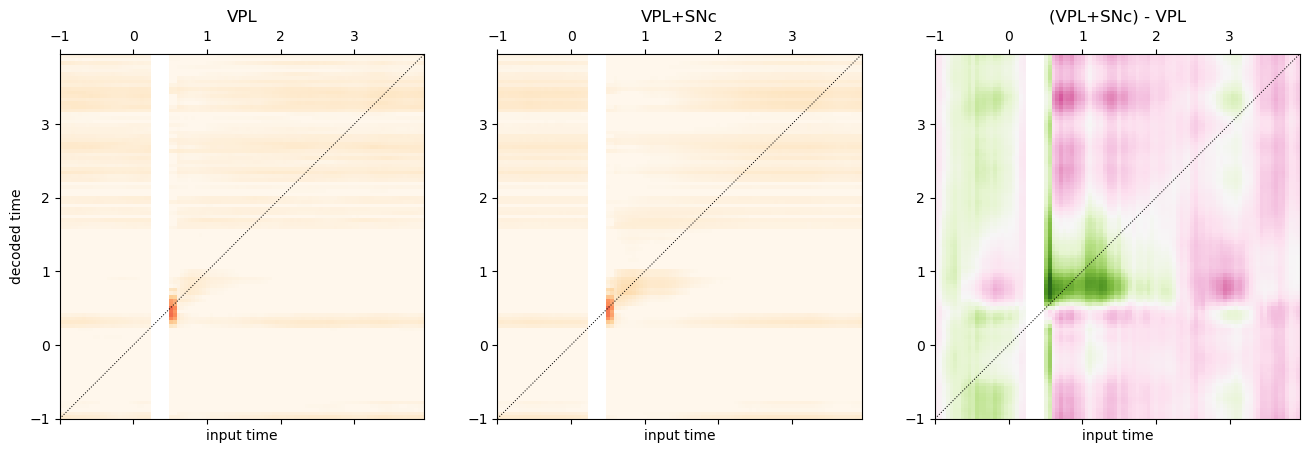

In [40]:
# plot
import matplotlib.pyplot as plt
# %matplotlib qt5
fig, axes = plt.subplots(ncols=3, figsize=[16,19])

vmin = 0
vmax = 0.5

vpl = np.average(all_Ls_vpl, axis=0) # <- transpose by manual verification
da = np.average(all_Ls_vpl_da, axis=0)

vpl_chance = np.average(all_Ls_vpl_chance, axis=0) # <- transpose by manual verification
da_chance = np.average(all_Ls_vpl_da_chance, axis=0)

ix = np.logical_and(tvec_decode > 0.25, tvec_decode < 0.5)
vpl[ix,:] = np.nan
da[ix,:] = np.nan
vpl = vpl.T
da = da.T
vpl_chance = vpl_chance.T
da_chance = da_chance.T

extent = (tvec_decode[0],tvec_decode[-1],tvec_decode[0],tvec_decode[-1])
kws = dict(vmin=vmin, vmax=vmax, origin='lower', extent=extent)

axes[0].matshow(vpl-vpl_chance, **kws, cmap='OrRd')
axes[1].matshow(da-da_chance, **kws, cmap='OrRd')

# axes[0].matshow(vpl, **kws, cmap='OrRd')
# axes[1].matshow(da, **kws, cmap='OrRd')


kws['vmin'] = -.05
kws['vmax'] = .05

axes[2].matshow(da-vpl, **kws, cmap='PiYG')

for ax in axes:
    ax.plot([tvec_decode[0], tvec_decode[-1]], [tvec_decode[0],tvec_decode[-1]], linestyle=':',lw=0.75, color='k')

for i, title in enumerate(['VPL','VPL+SNc', '(VPL+SNc) - VPL']):
    axes[i].set_title(title)

axes[0].set_ylabel('decoded time')
for ax in axes:
    ax.set_xlabel('input time')